# Dependencies and Data Loading

In [9]:
import os
import sys
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation, Dense, Flatten
from keras.layers.convolutional import Convolution1D,AveragePooling1D,MaxPooling1D

In [2]:
Mn2_C = (pd.read_pickle('input_spectra/Mn2_Larger_Clean_Thin.pkl'))
Mn3_C = (pd.read_pickle('input_spectra/Mn3_Larger_Clean_Thin.pkl'))
Mn4_C = (pd.read_pickle('input_spectra/Mn4_Larger_Clean_Thin.pkl'))
Mn_All = (Mn2_C.append(Mn3_C, ignore_index=True)).append(Mn4_C, ignore_index=True)
Mn_All = np.array(Mn_All)

labels=[]
for i in range(0, len(Mn2_C)):
    labels.append(0)
for i in range(0, len(Mn3_C)):
    labels.append(1)
for i in range(0, len(Mn4_C)):
    labels.append(2)

# Preprocessing

Total of 3 classes.
Data mean-centered, normalized and hot-encoded.
Total of 134200 training samples.


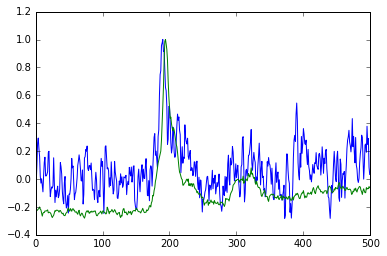

In [14]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(Mn_All, labels, test_size=0.15, random_state=13)

#data augmentation using principal components
noise_aug = []
noise = np.copy(X_train)
mu = np.mean(noise, axis=0)
pca = PCA()
noise_model = pca.fit(noise)
nComp = 10
Xhat = np.dot(pca.transform(noise)[:,:nComp], pca.components_[:nComp,:])
noise_level = np.dot(pca.transform(noise)[:,nComp:], pca.components_[nComp:,:])
Xhat += mu
SNR = np.linspace(1,5,50)
for i  in range(len(SNR)):
    noise_aug.append(SNR[i]*noise_level + Xhat)
    j = 0
    for spectra in noise_aug[i]:
        noise_aug[i][j] = spectra/np.max(spectra)
        j += 1
X_train = np.array(noise_aug).reshape(50*2684,700)
y_train = [item for i in range(50) for item in y_train]

#cropping
X_train = X_train[:,100:600]
X_test = X_test[:,100:600]

#formatting for keras
X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_train -=  np.mean(X_train)
X_train /= np.max(X_train)
X_test = np.array(X_test).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test -= np.mean(X_test)   
X_test /= np.max(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print("Total of "+str(num_classes)+" classes.")
print("Data mean-centered, normalized and hot-encoded.")
print("Total of "+str(len(X_train))+" training samples.")
plt.plot(X_test[0])
plt.plot(X_train[0])
plt.show()

# Model Architecture

In [5]:
model = Sequential()
activation = 'relu'
model.add(Convolution1D(2, 9, input_shape=(500,1), activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(2, 7, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(4, 7, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(4, 5, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(8, 3, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Dropout(0.10))
model.add(Convolution1D(3, 1))
model.add(GlobalAveragePooling1D())

model.add(Activation('softmax', name='loss'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
print("CNN Model created.")


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 492, 2)        20          convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
averagepooling1d_1 (AveragePooli (None, 246, 2)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 246, 2)        8           averagepooling1d_1[0][0]         
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 240, 2)        30          batchnormalization_1[0][0]       
___________________________________________________________________________________________

# Training

In [7]:
#Params
epochs = 1000
batch_size = 512
seed = 7

# fit and run our model
np.random.seed(seed)
best_model_file = "weights/CNN_Noise_DataAug/highest_val_acc_weights_epoch{epoch:02d}-val_acc{val_acc:.3f}_cnn.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_test, y_test),
                 nb_epoch=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)
print("done")

Train on 134200 samples, validate on 474 samples
Epoch 1/1000
134200/134200 [==============================] - 81s - loss: 0.8007 - acc: 0.6256 - val_loss: 1.2209 - val_acc: 0.3312
Epoch 2/1000
134200/134200 [==============================] - 3s - loss: 0.3813 - acc: 0.8910 - val_loss: 0.8770 - val_acc: 0.5359
Epoch 3/1000
134200/134200 [==============================] - 2s - loss: 0.2452 - acc: 0.9259 - val_loss: 0.2923 - val_acc: 0.8945
Epoch 4/1000
134200/134200 [==============================] - 3s - loss: 0.1908 - acc: 0.9405 - val_loss: 0.1606 - val_acc: 0.9494
Epoch 5/1000
134200/134200 [==============================] - 3s - loss: 0.1633 - acc: 0.9472 - val_loss: 0.1023 - val_acc: 0.9705
Epoch 6/1000
134200/134200 [==============================] - 3s - loss: 0.1487 - acc: 0.9500 - val_loss: 0.1225 - val_acc: 0.9599
Epoch 7/1000
134200/134200 [==============================] - 3s - loss: 0.1399 - acc: 0.9523 - val_loss: 0.0851 - val_acc: 0.9684
Epoch 8/1000
134200/134200 [=====

KeyboardInterrupt: 

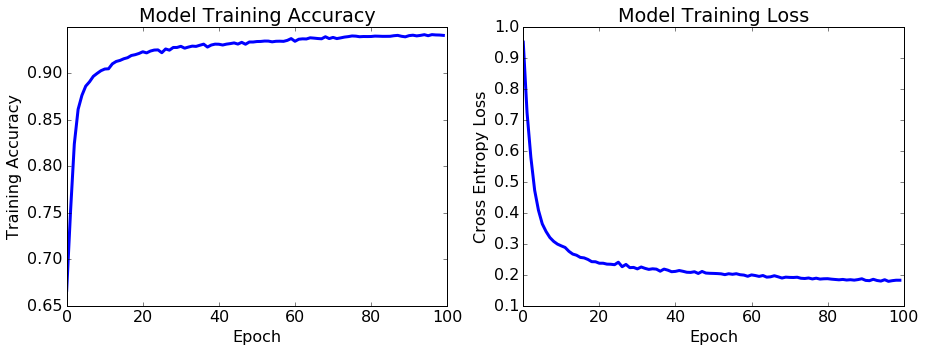

In [19]:
#summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

plt.subplot(1, 2, 1)
plt.plot(hist.history['acc'], linewidth = 3)
plt.title('Model Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], linewidth = 3)
plt.title('Model Training Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.savefig('figures/training_accuracy.png')
plt.show()

plt.figure(figsize=(10, 8))

plt.plot(hist.history['val_acc'], linewidth = 3)
plt.plot(hist.history['acc'], linewidth = 3)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='lower right')
plt.savefig('figures/test_accuracy.png')

plt.show()

# Testing Model Accuracy

In [10]:
y_test_pred, y_test_labels=[], []
for i in range(0, len(X_test)):
    y_test_pred.append(np.argmax(model.predict(X_test[i:i+1])))
    y_test_labels.append(np.argmax(y_test[i]))
print("Confusion Matrix of Test Set")
conf_matrix = pd.DataFrame(confusion_matrix(y_pred=y_test_pred, y_true=y_test_labels))
conf_matrix.columns = ["Mn2+", "Mn3+", "Mn4+" ]
conf_matrix = pd.DataFrame.transpose(conf_matrix)
conf_matrix.columns = ["Mn2+", "Mn3+", "Mn4+" ]
conf_matrix = pd.DataFrame.transpose(conf_matrix)
print(conf_matrix)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Confusion Matrix of Test Set
      Mn2+  Mn3+  Mn4+
Mn2+   148     8     1
Mn3+     0   136     5
Mn4+     0     2   174
Accuracy: 96.62%
